In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('clean_data.csv')

# Convert 'Date' to datetime and extract year, month, and day
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df.drop('Date', axis=1, inplace=True)  # Drop the original 'Date' column

label_encoder = LabelEncoder()
df['Type'] = label_encoder.fit_transform(df['Type'])

df.drop(['year', 'month', 'week'], axis=1, inplace=True)

In [ ]:
# Creating interaction terms
df['Store_Dept'] = df['Store'].astype(str) + '_' + df['Dept'].astype(str)
df['Type_Size'] = df['Type'].astype(str) + '_' + df['Size'].astype(str)

# Creating rolling averages and lag features
df.sort_values(by=['Store', 'Dept', 'Year', 'Month', 'Day'], inplace=True)

# Rolling averages for 4 weeks and 12 weeks
df['Rolling_Mean_4'] = df.groupby(['Store', 'Dept'])['Weekly_Sales'].transform(lambda x: x.rolling(window=4).mean())
df['Rolling_Mean_12'] = df.groupby(['Store', 'Dept'])['Weekly_Sales'].transform(lambda x: x.rolling(window=12).mean())

# Lag features for the previous week
df['Lag_1'] = df.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(1)

# Drop the first 12 rows for each group since they won't have complete rolling features
df = df.groupby(['Store', 'Dept']).apply(lambda x: x.iloc[12:]).reset_index(drop=True)

# Handling missing values in new columns
df.fillna(method='ffill', inplace=True)

# Encoding new categorical features
df['Store_Dept'] = label_encoder.fit_transform(df['Store_Dept'])
df['Type_Size'] = label_encoder.fit_transform(df['Type_Size'])

# Redefining FEATURES after adding new features
FEATURES = [i for i in df.columns if i != 'Weekly_Sales']

In [2]:
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(df[FEATURES], df['Weekly_Sales'], test_size=0.2, random_state=130)

In [4]:
# Train the Random Forest Regression model
rf_model = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1, max_depth=35, max_features = 'sqrt',min_samples_split = 10)
rf_model.fit(X_train, y_train)


RandomForestRegressor(max_depth=35, max_features='sqrt', min_samples_split=10,
                      n_estimators=50, n_jobs=-1, random_state=42)

In [5]:
# Making predictions
predictions_rf = rf_model.predict(X_test)

# Calculate the mean squared error and R^2 Score for Random Forest model
mse_rf = mean_squared_error(y_test, predictions_rf)
r2_rf = r2_score(y_test, predictions_rf)



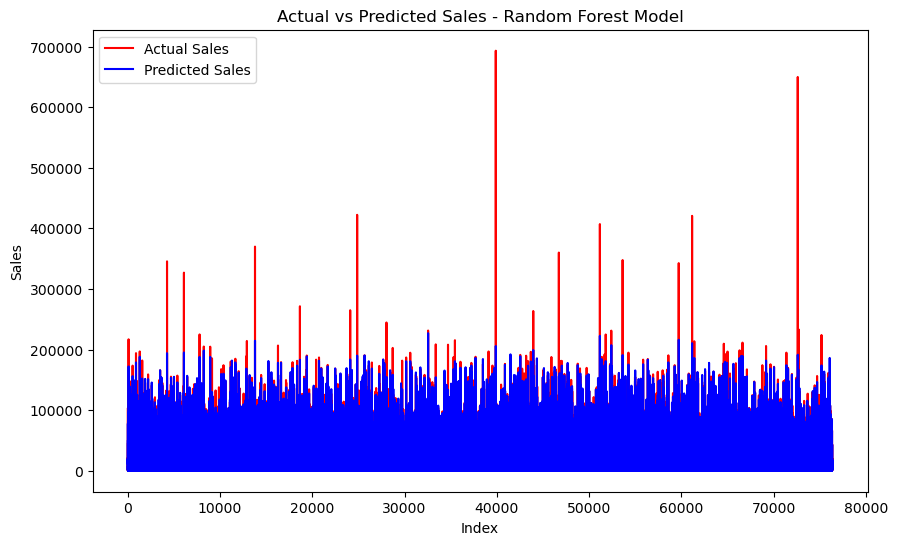

Mean Squared Error: 20920890.39
R-squared Score: 0.9608


In [11]:
import numpy as np
# Visualization using seaborn's lineplot
plt.figure(figsize=(10, 6))
sns.lineplot(x=np.arange(len(y_test)), y=y_test.values, color="red", label="Actual Sales")
sns.lineplot(x=np.arange(len(predictions_rf)), y=predictions_rf, color="blue", label="Predicted Sales")
plt.xlabel('Index')
plt.ylabel('Sales')
plt.title('Actual vs Predicted Sales - Random Forest Model')
plt.legend()
plt.show()

# Print the model's accuracy metrics
print(f"Mean Squared Error: {mse_rf:.2f}")
print(f"R-squared Score: {r2_rf:.4f}")



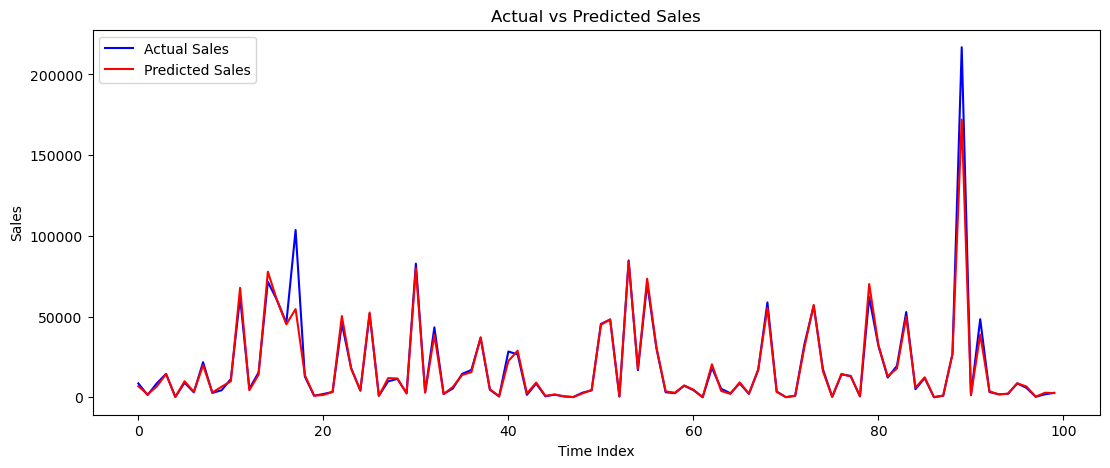

In [9]:
# Visualization using Seaborn
plt.figure(figsize=(13, 5))
sns.lineplot(x=np.arange(100), y=y_test[:100], label='Actual Sales', color='blue')
sns.lineplot(x=np.arange(100), y=predictions_rf[:100], label='Predicted Sales', color='red')  # 50% transparent red
plt.title('Actual vs Predicted Sales')
plt.xlabel('Time Index')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [8]:
sales_comparison = pd.DataFrame({
    'Actual Sales': y_test[:10].values,
    'Predicted Sales': predictions_rf[:10]
})
print(sales_comparison)

   Actual Sales  Predicted Sales
0       8617.40      6865.192199
1       1387.45      1793.222847
2       8670.00      6740.020728
3      14511.07     14413.890234
4        204.86       186.123040
5       9035.57      9937.519826
6       3063.83      3360.783412
7      21737.09     19854.087929
8       2696.82      2928.455762
9       4372.01      6528.341676


In [13]:
r2 = 0.9608 
# Converting R-squared score to a percentage
r2_percentage = r2 * 100

# Printing the accuracy as a percentage
print("Accuracy: {:.2f}%".format(r2_percentage))


Accuracy: 96.08%
